# Part 2: Sentiment analysis


_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).
>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 
>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.
>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?
>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 
>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).
>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 
>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

In [300]:
import nltk, re, pprint
from nltk import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.dates as mdate
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt
import re
import datetime as datetime

data = pd.read_csv("wallstreet_subs.csv", parse_dates = True)

In [301]:
data.head()

,created_utc,title,selftext,score
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1


Combining titles and main text

In [302]:
empty = []
for i in range(len(data['title'])):
    empty.append(data['title'][i]+' '+data['selftext'][i])
data['text'] = empty

>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

We pick November 4rd as d, which is the day after election day of the US presidential election.

OR

We pick March 13th as d, which is the day the president delcared a state of emergency in the country over the Corona virus

# to be written ^

Converting utc to datetime

In [303]:
data['date'] = [datetime.datetime.fromtimestamp(ts) for ts in data['created_utc']]
data['date'] = data['date'].dt.date
data['date'] = pd.to_datetime(data['date'])


In [304]:
data.set_index('date', inplace = True)

In [538]:
data.loc['2020-03-13']

,created_utc,title,selftext,score,text,daily_tokens,tokens
date,,,,,,,
2020-03-13,1584068356,Disney puts are printing tendies right now,They announce that they're shutting down their...,1,Disney puts are printing tendies right now The...,"[Disney, puts, are, printing, tendies, right, ...","[disney, puts, printing, tendies, right, annou..."
2020-03-13,1584068308,Carnival CCL $18 put exp 3/20,I already F'd up big time with my four CCL $21...,1,Carnival CCL $18 put exp 3/20 I already F'd up...,"[Carnival, CCL, $, 18, put, exp, 3/20, I, alre...","[carnival, ccl, put, exp, already, f, big, tim..."
2020-03-13,1584068143,Congrats u/wsjgod you virgin bastard,This fucker must have made 10s of millions tod...,1,Congrats u/wsjgod you virgin bastard This fuck...,"[Congrats, u/wsjgod, you, virgin, bastard, Thi...","[congrats, youwsjgod, virgin, bastard, fucker,..."
2020-03-13,1584068105,Thoughts on shorting HYG or JNK?,Basically junk bond etfs. They are down with a...,1,Thoughts on shorting HYG or JNK? Basically jun...,"[Thoughts, on, shorting, HYG, or, JNK, ?, Basi...","[thoughts, shorting, hyg, jnk, basically, junk..."
2020-03-13,1584068101,Thoughts on 2022 Calls,The longterm calls are now getting cheaper and...,1,Thoughts on 2022 Calls The longterm calls are ...,"[Thoughts, on, 2022, Calls, The, longterm, cal...","[thoughts, calls, longterm, calls, getting, ch..."
...,...,...,...,...,...,...,...
2020-03-13,1584101249,Germany promising companies limitless loans,Article in German: https://www.welt.de/vermisc...,1,Germany promising companies limitless loans Ar...,"[Germany, promising, companies, limitless, loa...","[germany, promising, companies, limitless, loa..."
2020-03-13,1584101182,Rise champion,There are a lot of people out there that are a...,1,Rise champion There are a lot of people out th...,"[Rise, champion, There, are, a, lot, of, peopl...","[rise, champion, lot, people, afraid, bitch, a..."
2020-03-13,1584101007,What time are you all YOLOing your puts at?,So I made a huge profit on my Ford puts and I ...,1,What time are you all YOLOing your puts at? So...,"[What, time, are, you, all, YOLOing, your, put...","[time, yoloing, puts, made, huge, profit, ford..."


>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively.

In [539]:
d = data.loc['2020-03-13'].index[0]
d_min = d - datetime.timedelta(days=7)

In [540]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            continue
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

In [541]:
#data['tokens'] = [preprocess(data['text'][i]) for i in range(len(data['text']))]

#^takes a long time to run

In [542]:
l = np.ndarray.tolist(np.concatenate(data.loc[d]['tokens']))

In [543]:
l_ref = []
date = d_min
while date <= d:
    l_ref.append(np.concatenate(data.loc[date]['tokens']))
    date += datetime.timedelta(days=1)
l_ref = [item for sublist in l_ref for item in sublist]
    

>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [544]:
from collections import Counter

In [545]:
p = dict([(item[0],item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0],item[1]/len(l_ref)) for item in Counter(l_ref).items()])

In [546]:
sorted(p.items(), key = lambda x:x[1],reverse=True)[:10]

[('puts', 0.011876339149066422),
 ('going', 0.00945821854912764),
 ('market', 0.008172635445362718),
 ('people', 0.00655035200489746),
 ('get', 0.006213651668197122),
 ('like', 0.006091215182124273),
 ('buy', 0.005693296602387512),
 ('go', 0.004897459442913988),
 ('spy', 0.004897459442913988),
 ('would', 0.0047444138353229266)]

In [547]:
sorted(p_ref.items(), key = lambda x:x[1],reverse=True)[:10]

[('puts', 0.008769190874114216),
 ('going', 0.007578443772921882),
 ('market', 0.007266203421942559),
 ('like', 0.005837306900511757),
 ('get', 0.005609741898950555),
 ('people', 0.005302793757309864),
 ('amp', 0.005011722243685071),
 ('buy', 0.004731235148737543),
 ('would', 0.004387241541726424),
 ('time', 0.004291981773631038)]

>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [548]:
all_tokens = set(p.keys()).union(set(p_ref.keys()))

In [549]:
dp = dict([(token, p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])

In [550]:
sorted(dp.items(), key = lambda x:x[1], reverse = True)[:10]

[('puts', 0.0031071482749522056),
 ('going', 0.0018797747762057584),
 ('trump', 0.0017760494170471043),
 ('today', 0.0013283633348227172),
 ('fucking', 0.0013010406639645039),
 ('next', 0.0012511225108896443),
 ('people', 0.0012475582475875956),
 ('weekend', 0.0009784937069499647),
 ('even', 0.0009724952217399995),
 ('buy', 0.0009620614536499685)]

# to be written

Notice anything interesting??

Not really...?

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [551]:
labMt_dict = pd.read_csv("Hedonometer.csv")
labMt_dict = labMt_dict.set_index("Word")

In [552]:
h = dict([(token, labMt_dict["Happiness Score"].get(token,np.nan)-5) for token in all_tokens])

In [553]:
dPhi = dict([(token,h[token]*dp[token]) for token in all_tokens if not np.isnan(h[token])])

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [554]:
sorted(dPhi.items(), key = lambda x:np.abs(x[1]), reverse = True)[:10]

[('coronavirus', 0.0030169009305166783),
 ('weekend', 0.002935481120849894),
 ('virus', 0.002394800329647459),
 ('earnings', -0.002179226544625695),
 ('emergency', -0.0017209639229117445),
 ('today', 0.0016206032684837146),
 ('good', 0.0015869197540159712),
 ('quarantine', -0.0015670364327013964),
 ('people', 0.001447167567201611),
 ('revenue', -0.001444114543956884)]

# We should talk about the results here

>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 

In [555]:
import shifterator as sh



In [560]:
sentiment_sh = sh.WeightedAvgShift(type2freq_1=p_ref,
                    type2freq_2=p,
                    type2score_1 = 'labMT_English',
                    reference_value=5)

C:\Users\rune7\anaconda3\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


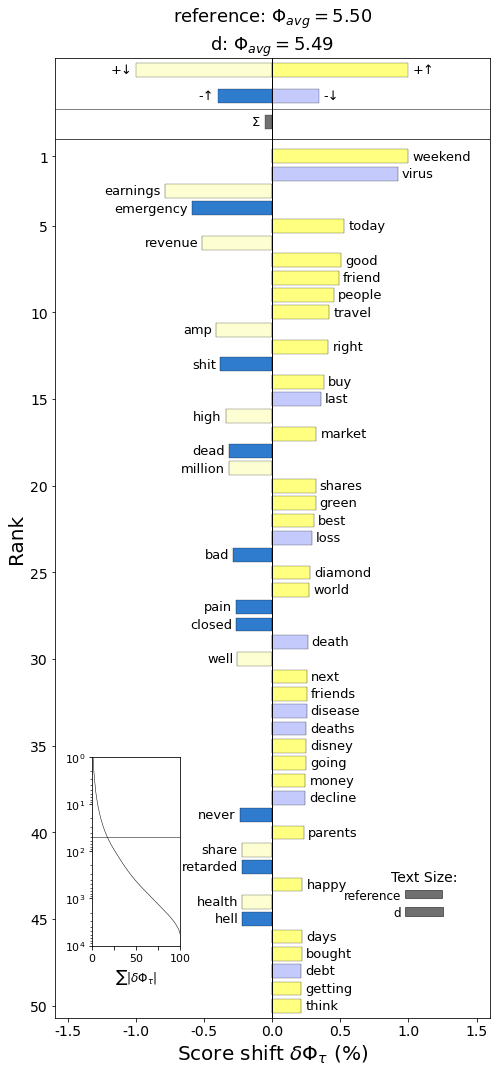

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.50\nd: $\\Phi_{avg}=$5.49'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [557]:
sentiment_sh.get_shift_graph(detailed= True,
                            system_names = ['reference', 'd'])